<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Добавление-признаков" data-toc-modified-id="Добавление-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Добавление признаков</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-дерева-решений" data-toc-modified-id="Модель-дерева-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель дерева решений</a></span></li><li><span><a href="#Модель-Catboost" data-toc-modified-id="Модель-Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель Catboost</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

* Целевая метрика - *RMSE* (на тестовой выборке должно быть не больше 48).

План проекта:

1. Загрузка данных и их ресемплирование по одному часу.
2. Анализ данных.
3. Обучение разных моделей с различными гиперпараметрами.
4. Проверка данных на тестовой выборке и формулирование выводов.

## Подготовка

Для начала загрузим необходимые для работы библиотеки и классы.

In [1]:
# Загрузка основных библиотек для работы с данными и визуализацией
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

# Загрузка метода декомпозиции временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Загрузка библиотек для подготовки данных
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Загрузка моделей
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool, CatBoost

# Загрузка метрик качества моделей
from sklearn.metrics import mean_squared_error

Загрузим данные и сохраним их в переменную `taxi`.

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Выведем основную информацию о датафрейме и первые 10 строк датафрейма.

In [3]:
display(taxi.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Как мы можем видеть из выгрузок выше, датасет состоит всего из двух столбцов:
- `datetime` - содержит данные о дате и временном промежутке в размере 10 минут. Данные в этом столбце мы сразу преобразовали в формат даты, а также установили его в качестве индекса;
- `num_orders` - количество заказов такси, сделанное в этом промежутке.

Датафрейм содержит 26496 наблюдений. Колонках отсутствуют явные пропуски.

In [5]:
taxi.query('num_orders<=0').sort_values(by='num_orders')

,num_orders
datetime,
2018-03-01 05:20:00,0
2018-04-29 06:50:00,0
2018-04-29 06:30:00,0
2018-04-29 06:20:00,0
2018-04-29 06:10:00,0
...,...
2018-03-28 14:30:00,0
2018-03-28 06:50:00,0
2018-03-28 06:00:00,0


В датафрейме модержатся данные о 537 10-минутных промежутках, когда заказов такси не было. Необычных отрицательных значений не обнаружено.

Поскольку нам необходимо спрогнозировать количество заказов на следующий час, проведем ресемплирование данных. С десяти минутными промежутками нам будет неудобно работать, поэтому изменим интервал на 1 час. Так как у нас задано количество заказов, в качестве агрегирующей функции выберем функцию суммы.

In [6]:
# Ресемплируем данные
taxi = taxi.resample('1H').sum()

# Отсортируем данные
taxi.sort_index(inplace=True)
print('Данные в хронологическом порядке (True/False)?', taxi.index.is_monotonic)

# Выведем первые 5 строк для проверки
display(taxi.head())

Данные в хронологическом порядке (True/False)? True


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

### Анализ данных

Проведем анализ преобразованного датасета. Для начала еще раз выгрузим информацию о датасете.

In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Ресемплирование значительно сократило количество строк в датасете. Также мы видим, что в основной информации появилась частота, c которой указаны данные в датасете (`Freq: H`).

Мы также можем видеть, что в датасете представлены данные о количестве заказов такси в период с полуночи (00 часов) 01 марта 2018 года по 11 часов вечера (23 часа) 31 августа 2018 года.

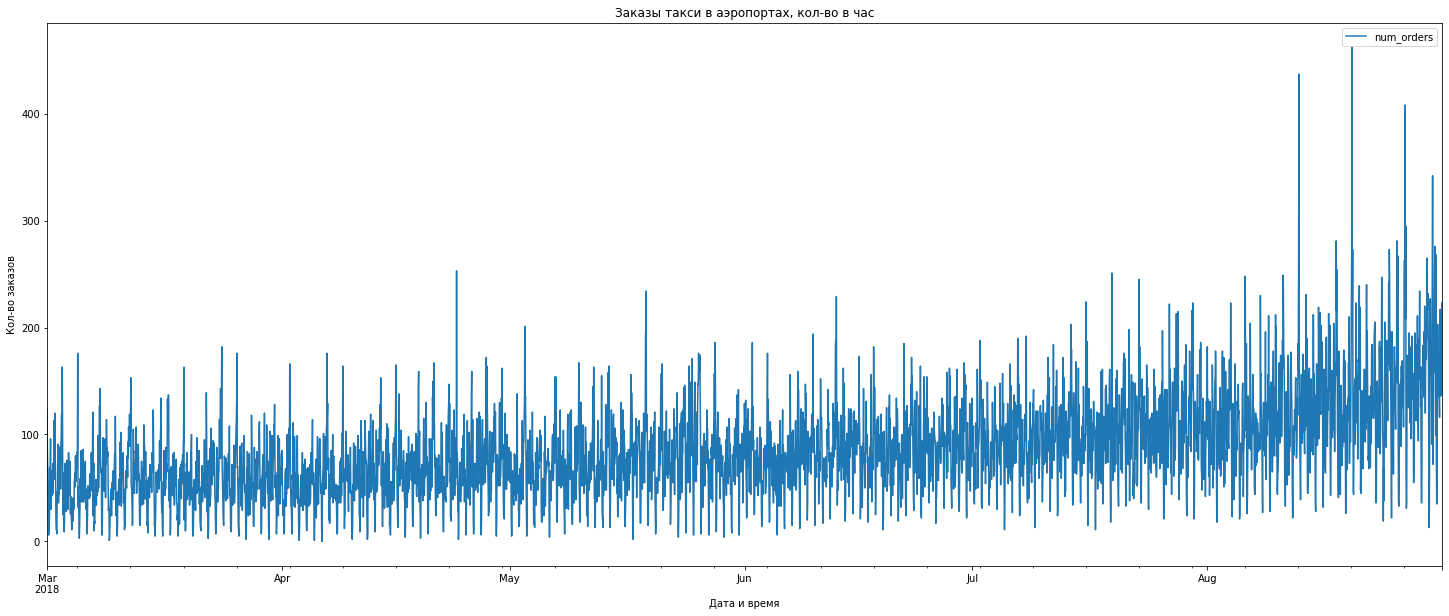

In [8]:
def orders_plot(data, period=''):
    ax = data.plot(title='Заказы такси в аэропортах'+period+', кол-во в час',
                           xlabel='Дата и время', 
                           ylabel='Кол-во заказов',
                           figsize=(25,10));

orders_plot(taxi)

По привиденному выше графику сложно что-то сказать, кроме того, что похоже, что:
- разброс количества заказов за рассматриваемый период является визуально плюс-минус постоянным;
- к концу августа заказов в среднем стало чуть больше, чем в начале марта, иными словами мы видим тренд роста количества заказов за рассматриваемый период. Подобный тренд вполне может быть связан с сезоном отпусков летом. 

Связан ли рост среднего числа заказов с отпусками или нет, но это в любом случае говорит нам о том, что мы можем иметь дело с нестационарным временным рядом. Проверим это чуть позже.

Из-за большой частоты заказов на графике выше сложно сказать, присутствует ли в количестве заказов какая-либо сезонность. Поэтому попробуем рассмотреть данные за более короткий период, например, первую половину июня.

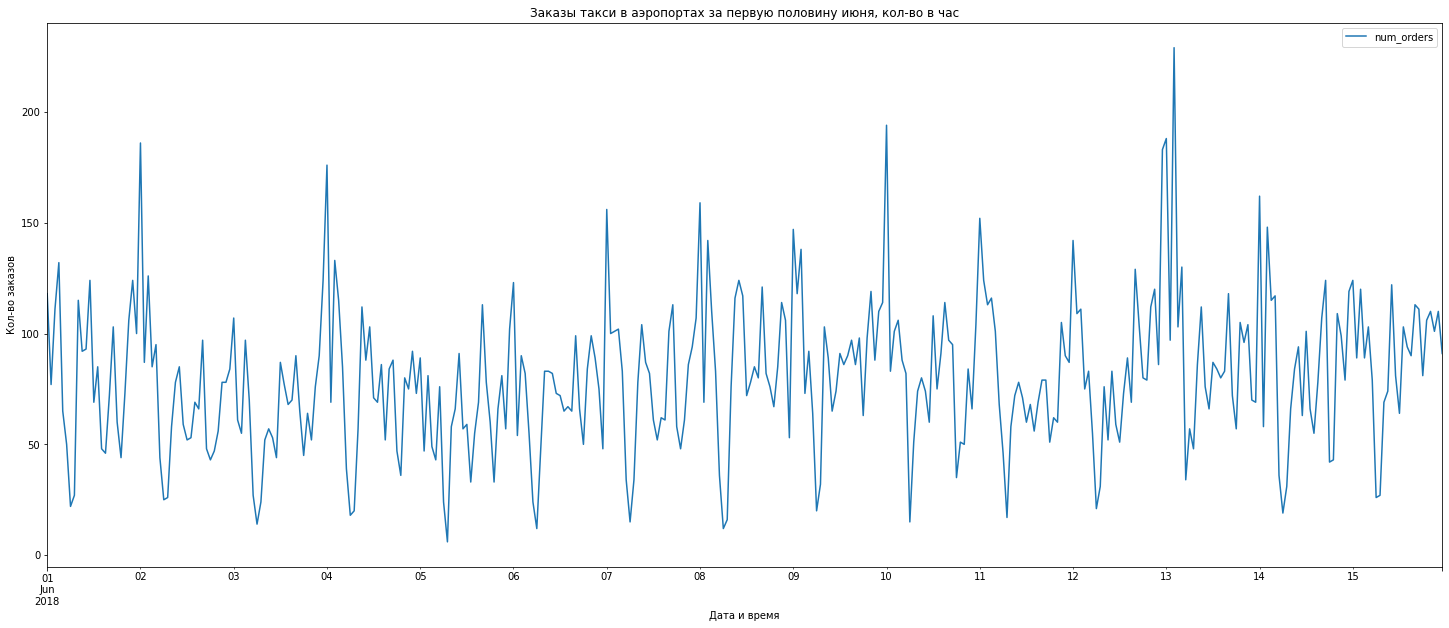

In [9]:
orders_plot(taxi['2018-06-01':'2018-06-15'], ' за первую половину июня')

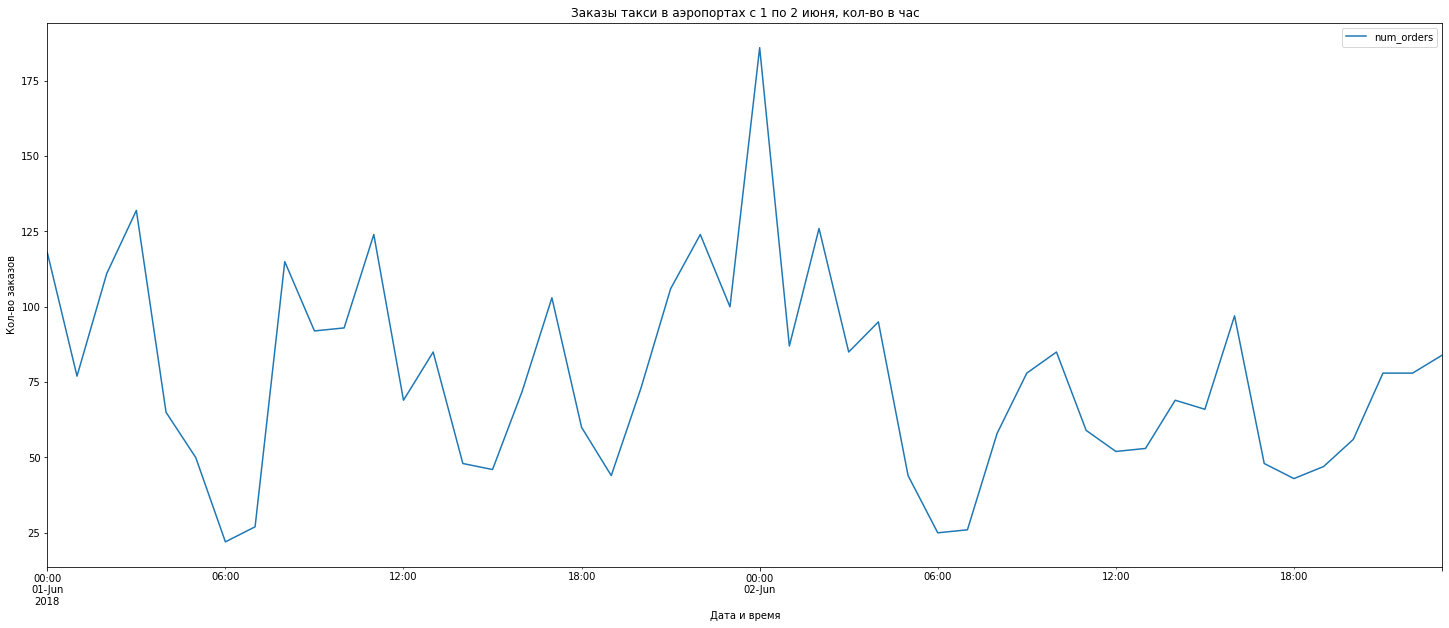

In [10]:
orders_plot(taxi['2018-06-01':'2018-06-02'], ' с 1 по 2 июня')

Многое в этом мире циклично, в том числе и количество заказов такси. На графиках выше видно, что количество заказов меняется периодично в течение дня: 
- минимальное количество заказов в день - в районе 6:00;
- локальные минимумы  - в 12:00 и в 18:00;
- максимальное количество заказов в 00:00.

Также мы видим, что в какие-то дни число заказов в пиковые часы значительно больше, чем в другие. Исходя из этого, среди возможных признаков стоит рассмотреть следующие:
- час;
- день недели;
- выходной/праздничный день.

Если бы данные были даны за более продолжительный период, можно было бы оценить сезонность внутри года с помощью месяцов и сезонов.

Для проверки наших выводов о наличии восходящего тренда и суточной сезонности декомпозируем временной ряд с помощью модуля **tsa.seasonal**. Посмотрим декомпозицию на нескольких уровнях:
- за весь период;
- за один месяц;
- за 1 неделю.

In [11]:
# Раздложим временной ряд для всего периода
taxi_decomposed = seasonal_decompose(taxi)
# Раздложим временной ряд за июнь
taxi_decomposed_june = seasonal_decompose(taxi['2018-06-01':'2018-06-30'])
# Раздложим временной ряд за первую полную неделю июня
taxi_decomposed_week = seasonal_decompose(taxi['2018-06-04':'2018-06-10'])

In [12]:
# Зададим функцию для разложения временного ряда на тренд, сезонность и остатки
def decomposed_plot(data, period=''):
    plt.figure(figsize=(25, 30))
    plt.subplot(311)
    data.trend.plot(ax=plt.gca())
    plt.title('Тренд ' + period)

    plt.subplot(312)
    data.seasonal.plot(ax=plt.gca())
    plt.title('Сезонность ' + period)

    plt.subplot(313)
    data.resid.plot(ax=plt.gca())
    plt.title('Остатки ' + period)
    plt.tight_layout()

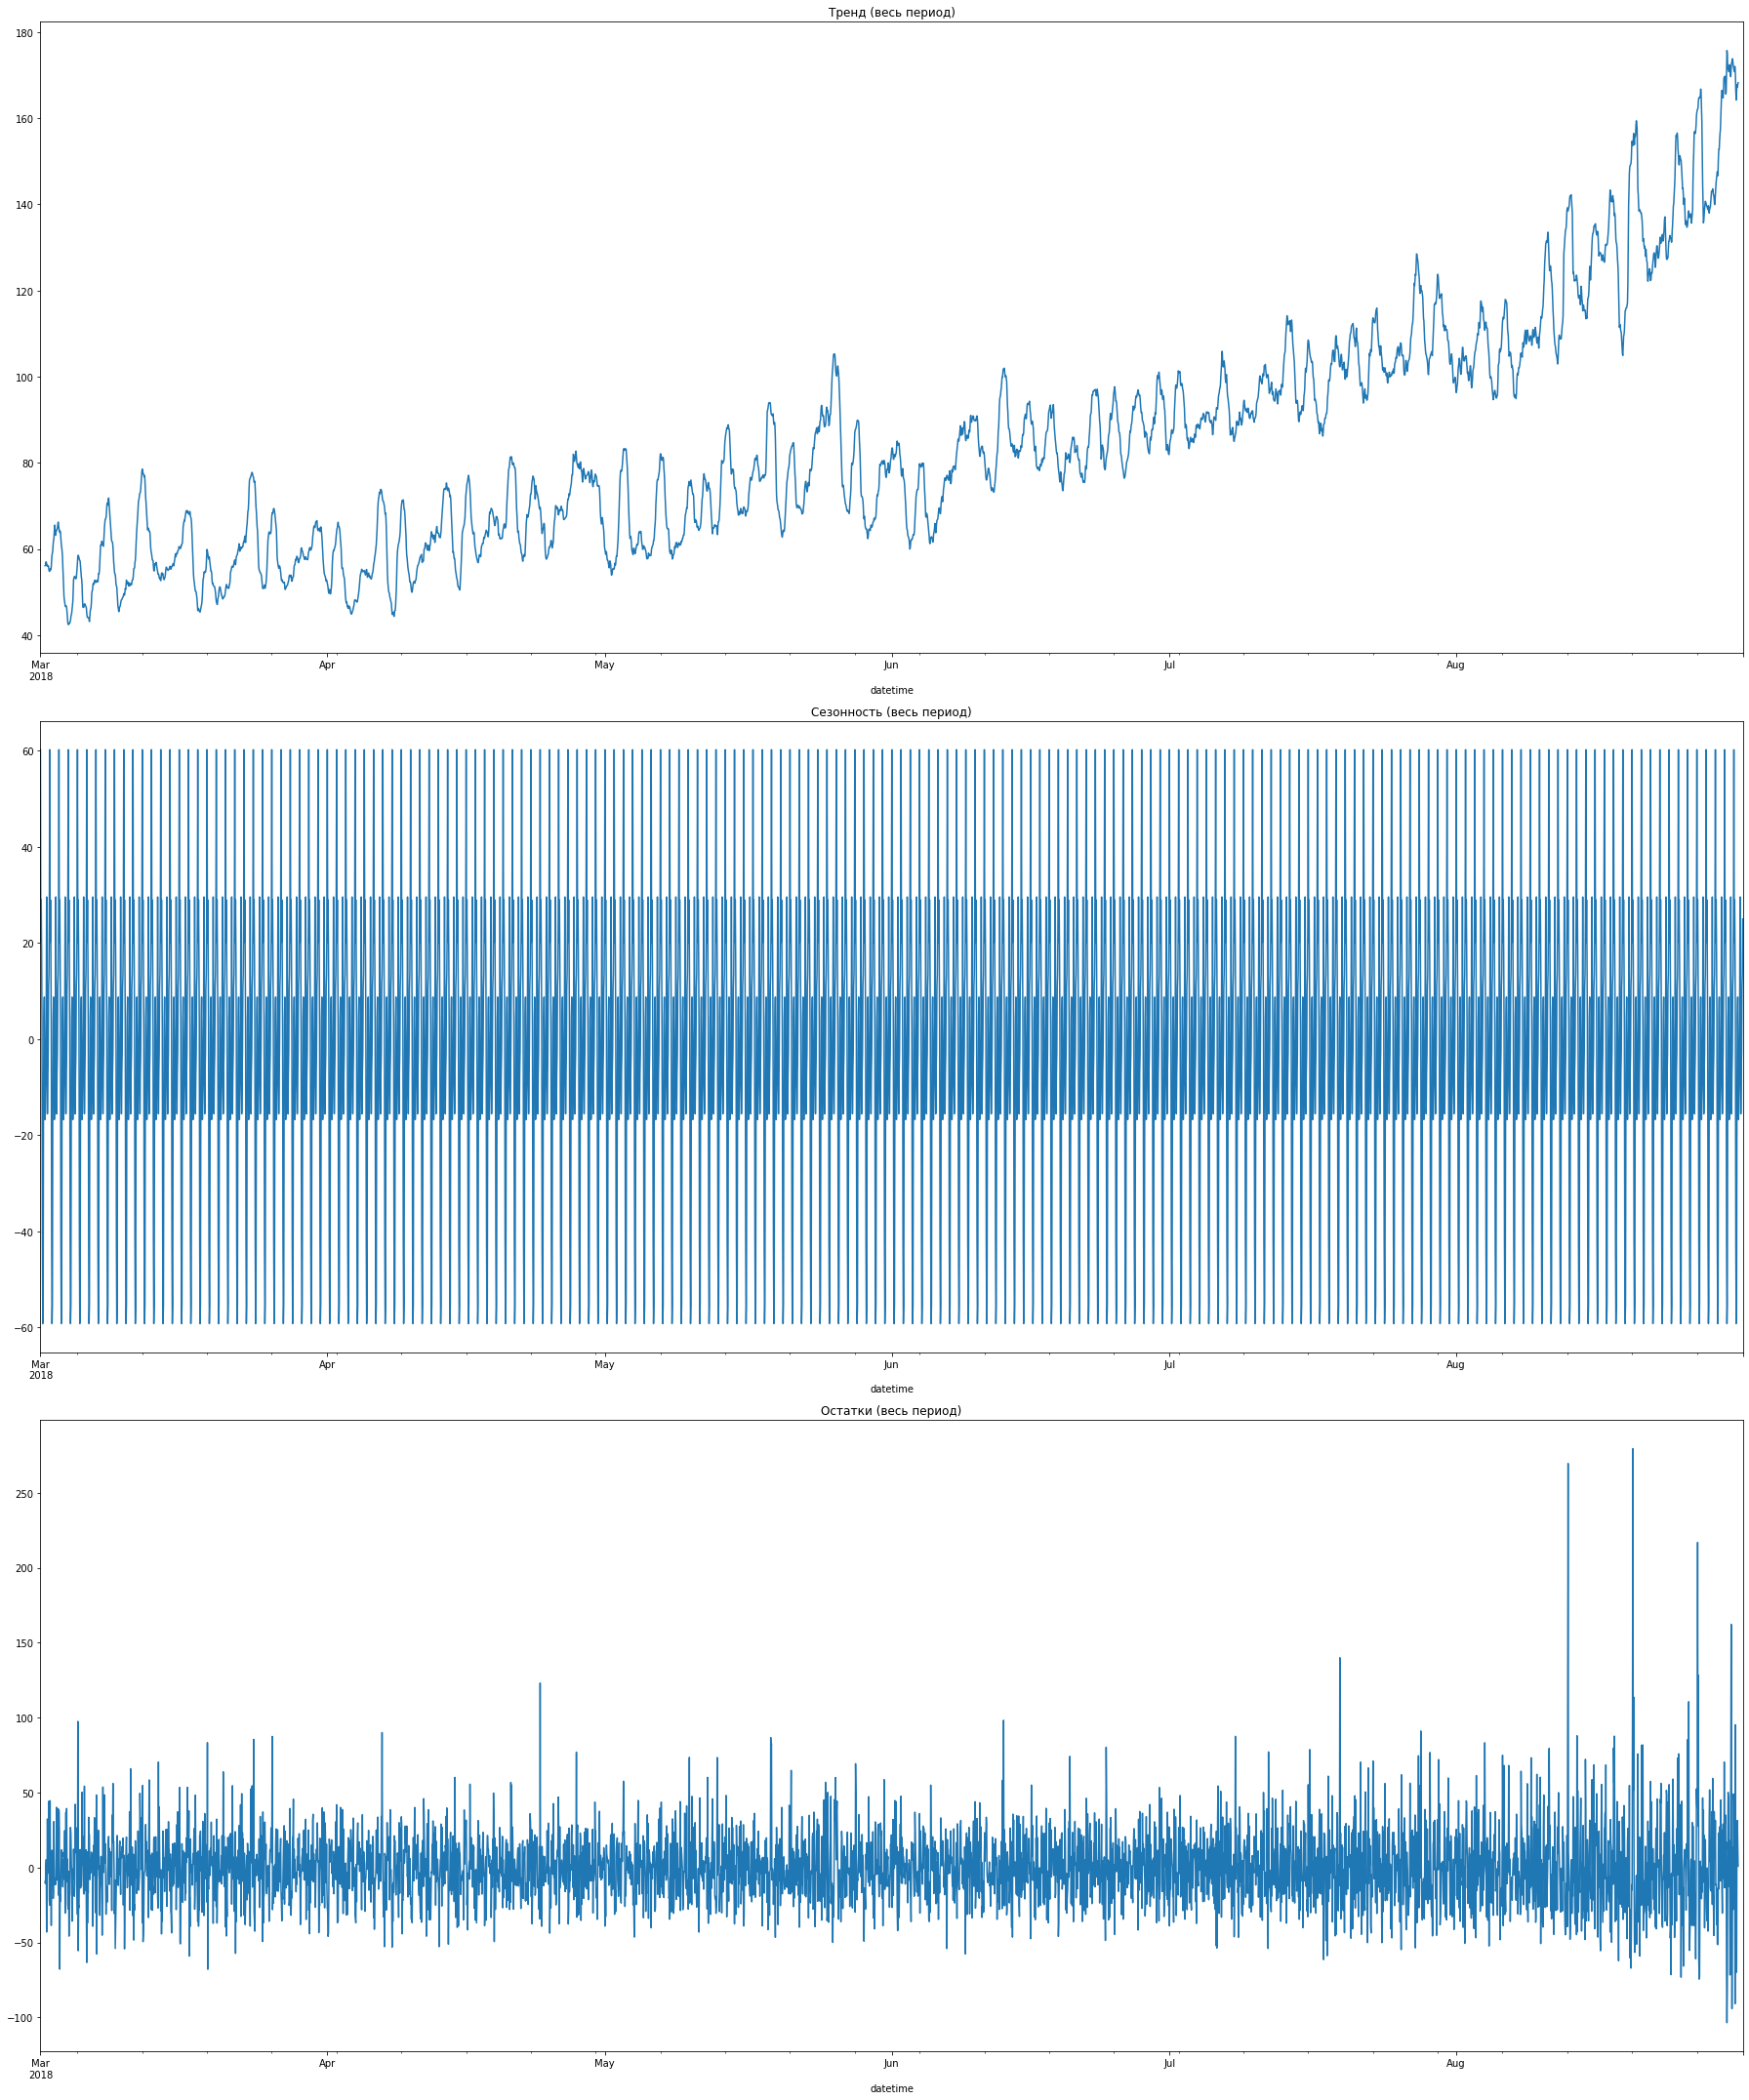

In [13]:
decomposed_plot(taxi_decomposed, '(весь период)')

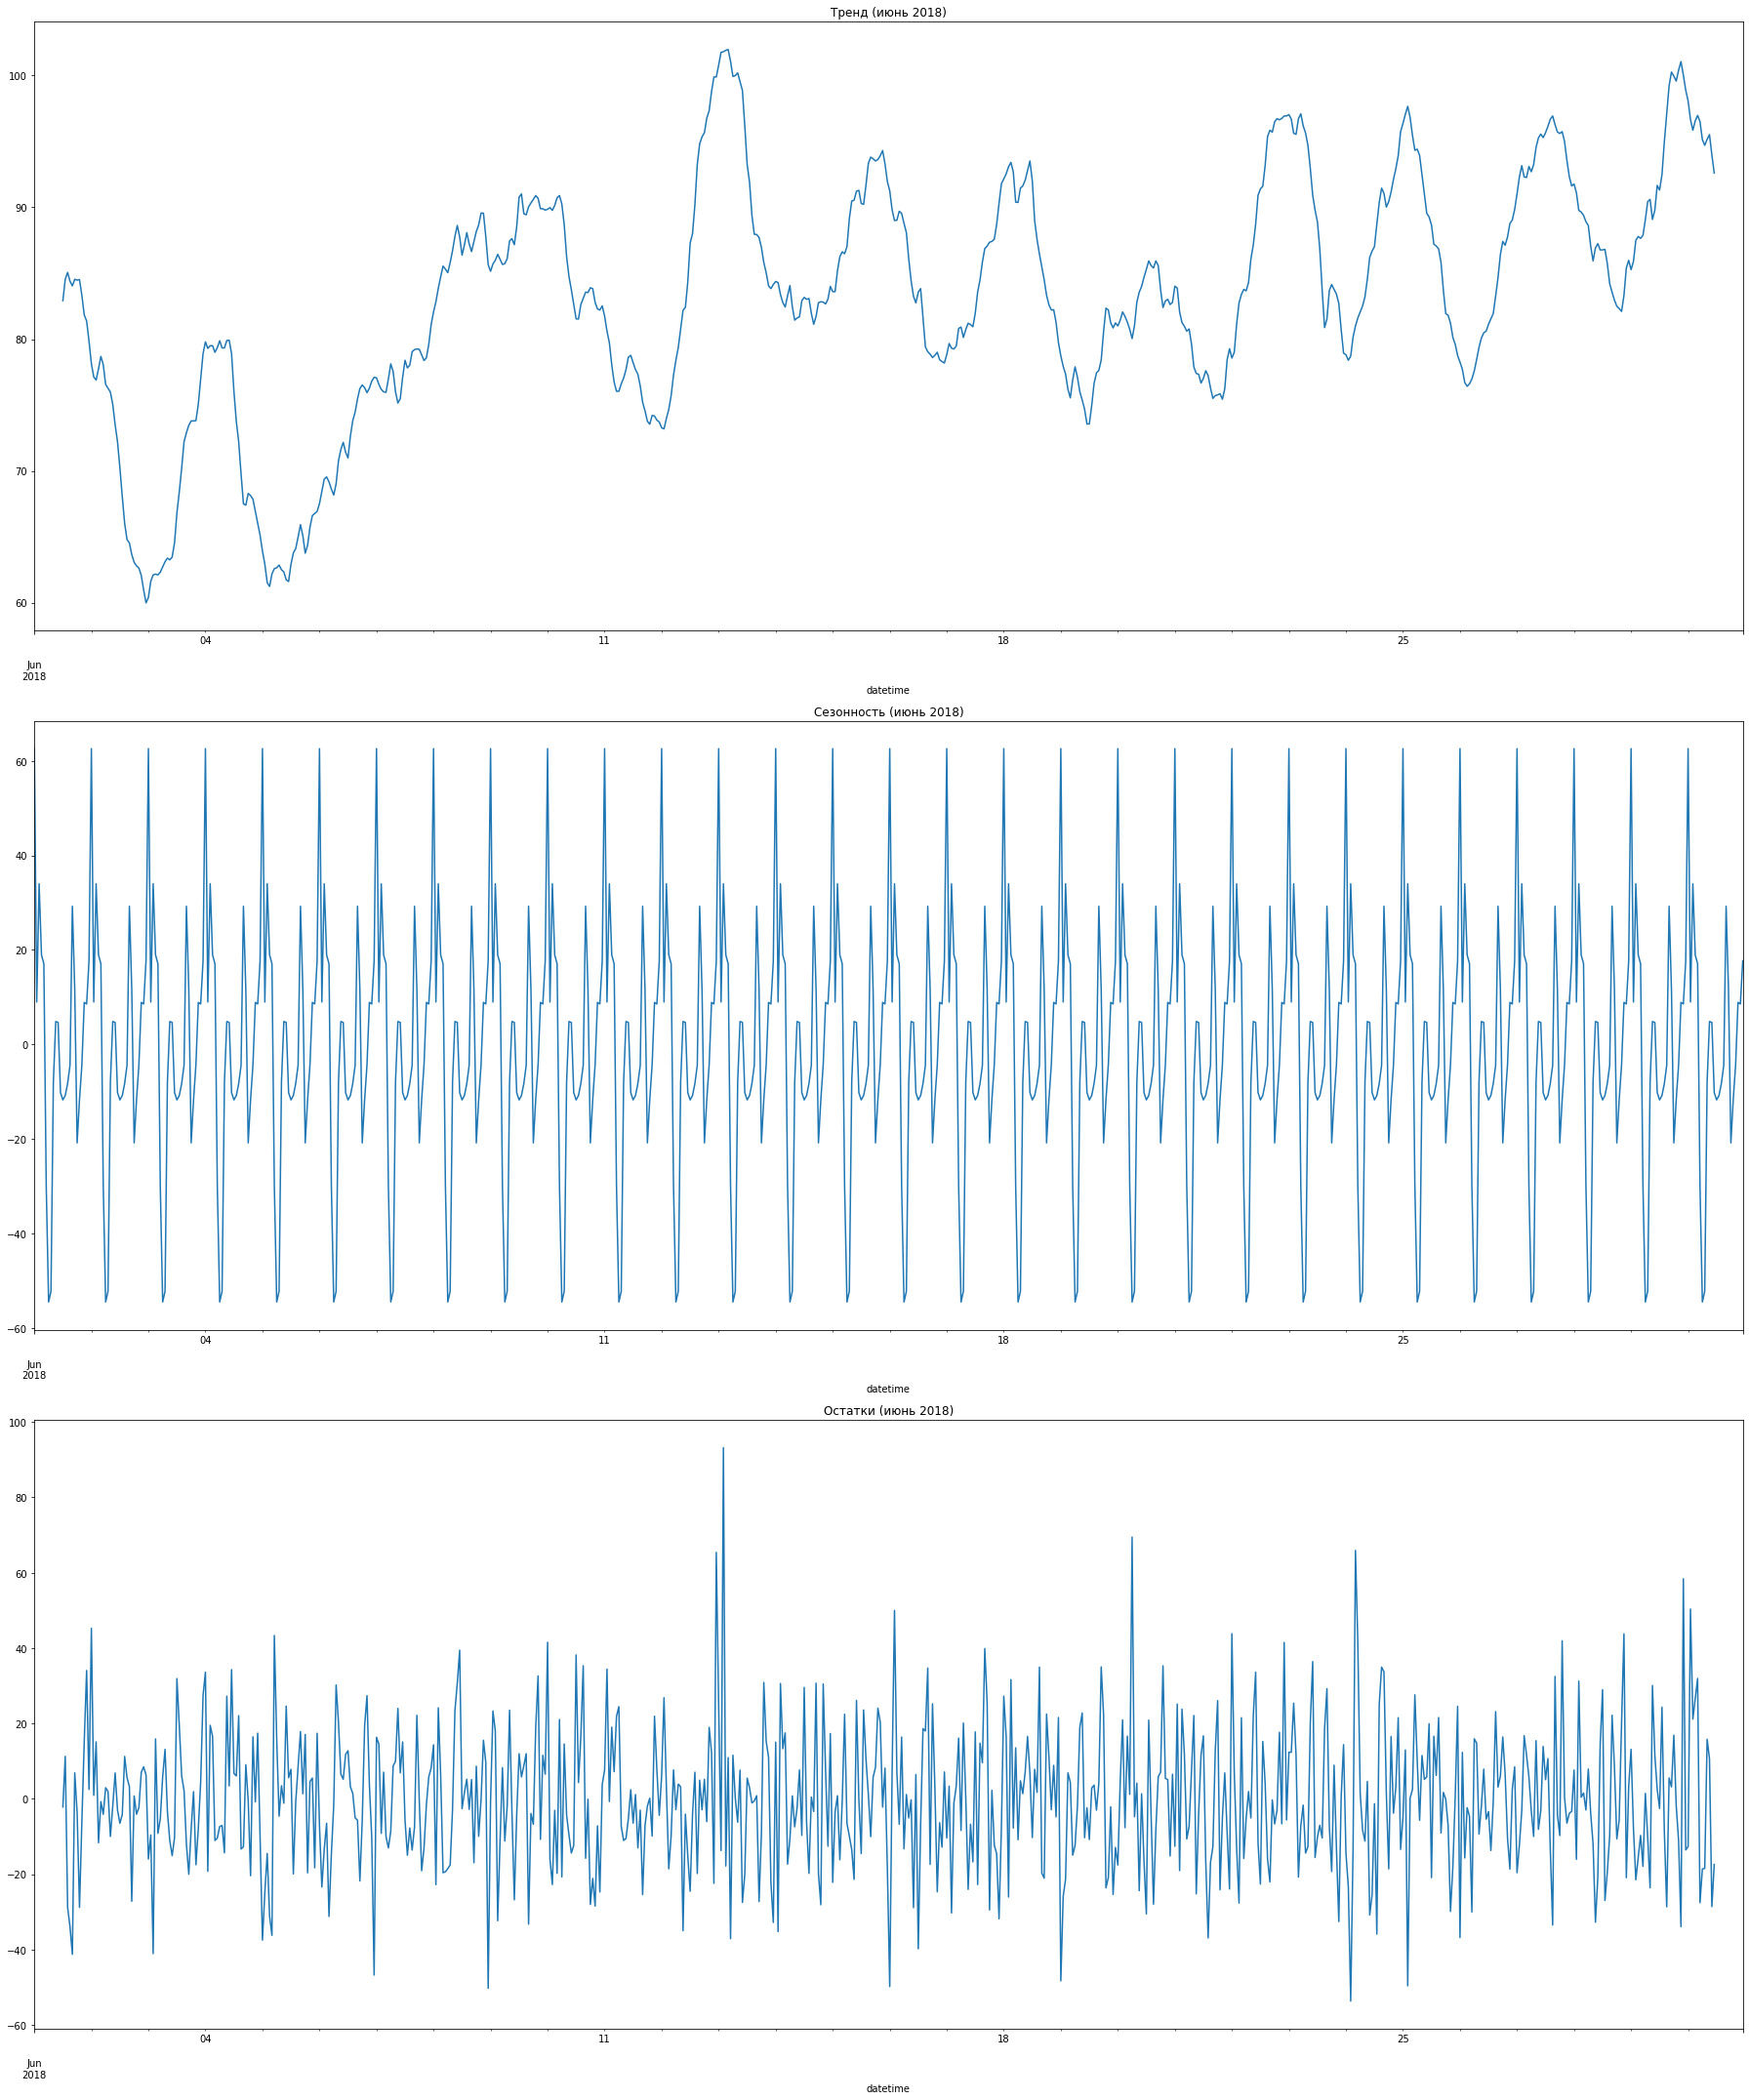

In [14]:
decomposed_plot(taxi_decomposed_june, '(июнь 2018)')

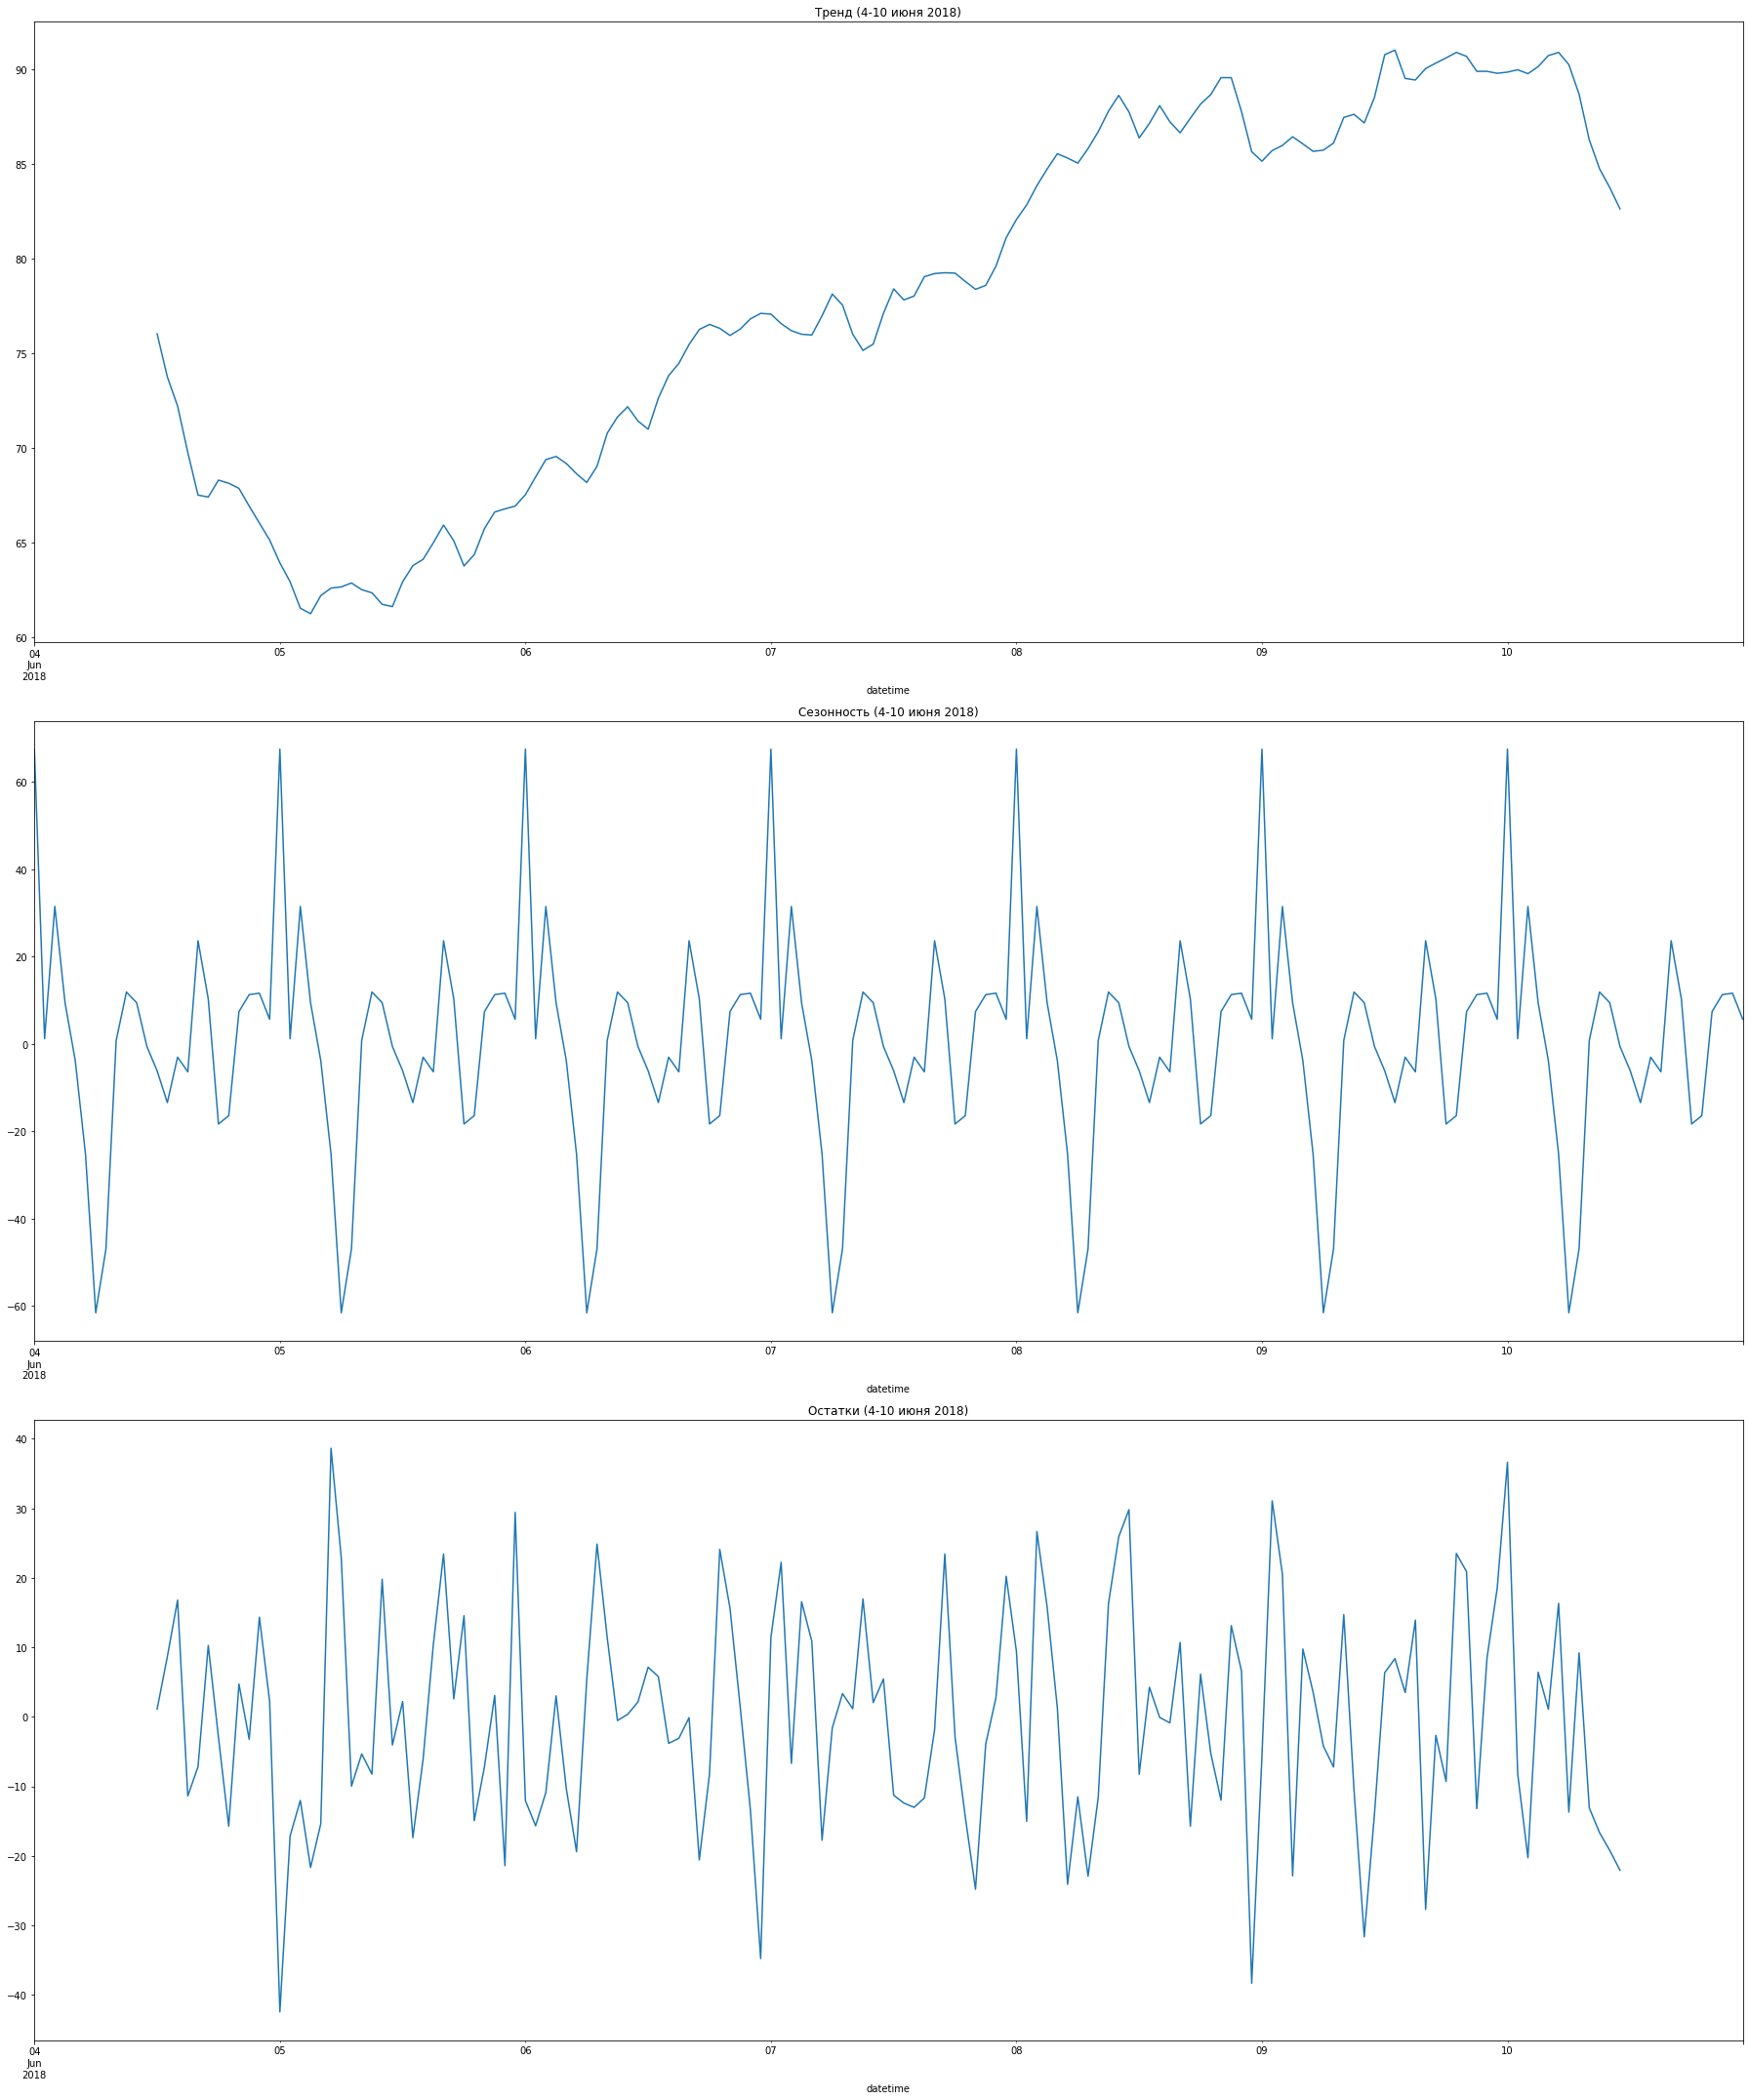

In [15]:
decomposed_plot(taxi_decomposed_week, '(4-10 июня 2018)')

Из графиков выше можно сказать следующее:
- На графиках тренда за весь период и отдельно за июнь очень хорошо видно возрастающий тренд. Сложно сказать, c чем это связано в виду ограниченного периода времени. Этот рост может быть связан с большей загруженностью аэропорта в период отпусков и соответственно иметь сезонный характер.
- На всех графиках сезонности (более четко на графике с 4 по 10 июня) видна суточная сезонность.
- Мы также видим, что помимо тренда и сезонности на количество заказов такси влияют и другие факторы (график остатков). Примечательно, что график остатков за весь период достаточно ровный: средняя и стандартное отклонение остатков не меняются во времени. Однако примерно с середины августа мы видим несколько крупных выбросов.

Выше мы говорили о том, что наш временной ряд может быть нестационарным. Наличие ярко выраженного тренда и сезонности подтверждает это. Проверим это с помощью расширенного теста Дики-Фуллера, а также графически. 

В расширенном тесте Дики-Фуллера используются следующие нулевая и альтернативная гипотезы:

- H0 : Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

- HA : временной ряд является стационарным.

Для графической проверки добавим в данные скользящее среднее и скользящее стандартное отклонение и выведем их на графике. Размер окна выберем равным 24 часам, поскольку ранее мы обнаружили суточную сезонность в количестве заказов такси.

In [16]:
test = sm.tsa.adfuller(taxi['num_orders'])
print('Статистика теста: ', test[0])
print('p-value: ', test[1])
print('Критические значения на разных уровнях значимости: ', test[4])
if test[0]> test[4]['1%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

Статистика теста:  -3.0689242890279558
p-value:  0.028940051402612906
Критические значения на разных уровнях значимости:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
есть единичные корни, ряд не стационарен


Расширенный тест Дики-Фуллера на разных уровнях значимости дает разный результат. Поэтому мы не можем отвергать нулевую гипотезу о том, что ряд нестационарен. Посмотрим, что покажет графическая проверка.

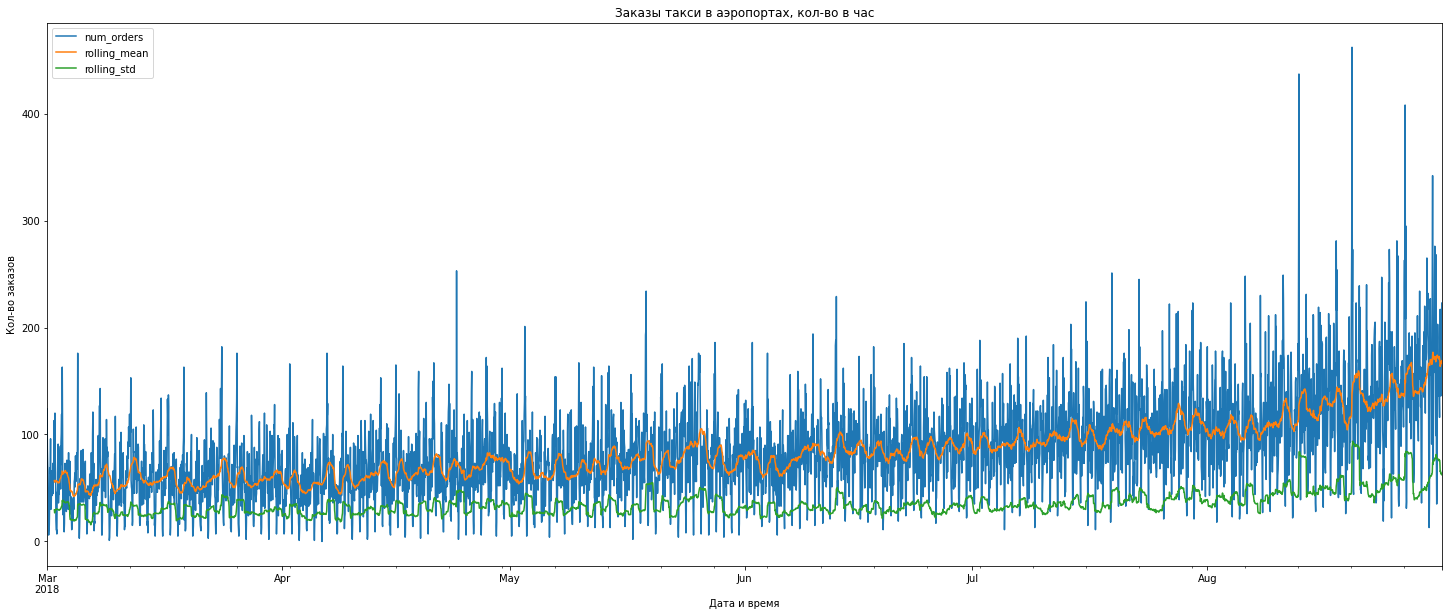

In [17]:
# Добавим скользящие среднее и стандартное отклонение
taxi['rolling_mean'] = taxi['num_orders'].rolling(24).mean()
taxi['rolling_std'] = taxi['num_orders'].rolling(24).std()
orders_plot(taxi)

Как мы можем видеть на графике, к концу рассматриваемого периода возрастает не только скользящее среднее, но и под конец становится больше стандартное отклонение.  
Посмотрим, получим ли мы более стационарный ряд, если найдем разность временного ряда со сдвигом на один день.

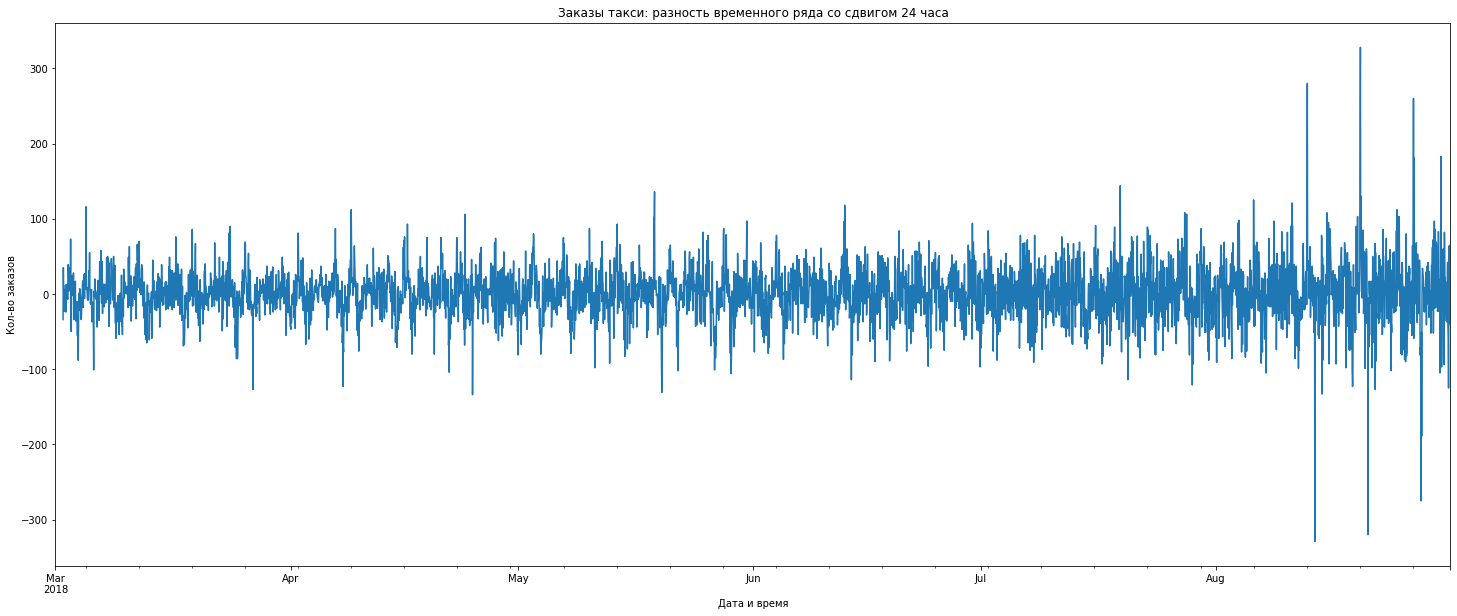

In [18]:
((taxi['num_orders']-taxi['num_orders'].shift(24))
 .plot(title='Заказы такси: разность временного ряда со сдвигом 24 часа',
       xlabel='Дата и время', 
       ylabel='Кол-во заказов',
       figsize=(25,10)));

При вычислении разности временного ряда со сдвигом в 24 часа мы действительно получаем более стационарный временной ряд. В конце августа мы все еще видим несколько крупных выбросов, но как мы выяснили, они связаны с факторами, которые мы не можем учесть в модели.

Удалим столбцы `rolling_mean` и `rolling_std`, чтобы избежать утечки данных.

In [19]:
# Удаление столбцов
taxi = taxi.drop(['rolling_mean', 'rolling_std'],axis=1)
# Проверка
display(taxi.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Добавление признаков

На основе проведенного выше анализа в состав признаков для прогнозирования количества заказов такси, помимо скользящего среднего за 24 часа, добавим следующие:
- час;
- день;
- день недели;
- месяц;
- выходной день (1/0);
- сдвиг на 24 часа.

Также в виду наличия выбросов попробуем их сгладить с помощью скользящей средней за несколько дней. Например, за 5 дней.

In [21]:
# Зададим функцию для проставления признака выходного дня
def weekend(dayofweek):
    if dayofweek<=4:
        return 0
    else:
        return 1

# Зададим функцию создания новых признаков
def make_features(data, lag, rolling_mean_size):
    
    data_new_cols = data.copy()
    data_new_cols['hour'] = data_new_cols.index.hour
    data_new_cols['day'] = data_new_cols.index.day
    data_new_cols['dayofweek'] = data_new_cols.index.dayofweek
    data_new_cols['month'] = data_new_cols.index.month
    data_new_cols['weekend'] = data_new_cols['dayofweek'].apply(weekend)
    
    data_new_cols['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data_new_cols['rolling_mean'] = data['num_orders'].shift().rolling(lag).mean()
    data_new_cols['rolling_mean_5d'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new_cols

In [22]:
df_taxi = make_features(taxi, 24, 120)
display(df_taxi.head(15))

,num_orders,hour,day,dayofweek,month,weekend,lag_24,rolling_mean,rolling_mean_5d
datetime,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,3,0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,3,0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,0,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,3,0,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,1,3,3,0,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,1,3,3,0,NaN,NaN,NaN
2018-03-01 07:00:00,15,7,1,3,3,0,NaN,NaN,NaN
2018-03-01 08:00:00,34,8,1,3,3,0,NaN,NaN,NaN


### Подготовка данных

Разделим выборку на тренировочную и тестовую. В тренировочной выборке удалим строки с пустыми значениями, которые мы получили в сдвигах и скользящей средней. Размер тестовой выборки установим равным 10%.

In [23]:
# Разделим выборку на тренировочную и тестовую
train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)

# Проверим размер выборок до удаления NaN
print(train.shape)
print(test.shape)

(3974, 9)
(442, 9)


In [24]:
# Удалим пропуски из тренировочной выборки
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

# Проверим размер выборок
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3854, 8) (3854,)
(442, 8) (442,)


Все признаки, которые мы будем использовать для прогнозирования количества заказов, являются количественными. Масштаб этих признаков незначительно, но различается. Поэтому перед обучением моделей масштабируем признаки с помощью StandardScaler.

In [25]:
# Зададим функцию для мвсштабирования данных
def scale_data(train, test):
    # Зададим список столбцов для обработки
    num_cols = train.columns.to_list()

    # Масштабируем признаки
    scaler = StandardScaler()
    
    train_scaled = scaler.fit_transform(train[num_cols])
    train_scaled = pd.DataFrame(train_scaled, columns=num_cols)
    
    test_scaled = scaler.transform(test[num_cols])
    test_scaled = pd.DataFrame(test_scaled, columns=num_cols)
    
    return scaler, train_scaled, test_scaled

In [26]:
scaler, X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

## Обучение

### Модель линейной регрессии

Для начала обучим простую модель линейной регрессии и посмотрим, какой ошибкой она будет обладать.

In [27]:
model_linear = LinearRegression()
model_linear.fit(X_train_scaled, y_train)
preds = model_linear.predict(X_test_scaled)
rmse_linear = mean_squared_error(y_test,preds,squared=False)
print('RMSE:', rmse_linear)

RMSE: 49.94196822057936


### Модель дерева решений

Попробуем обучить более сложные модели с различными гиперпараметрами. В качестве первой модели выберем `DesicionTreeRegressor` со следующим набором гиперпараметров:
- минимальное количество объектов в узле для разделения `min_samples_split` из диапазона от 2 до 5 включительно;
- минимальное количество объектов в листе `min_samples_leaf` из диапазона от 1 до 5 включительно;
- максимальная глубина дерева `max_depth` из диапазона от 2 до 8 включительно.

Для подбора модели с лучшими гиперпараметрами нам потребуется кросс-валидация. Однако при работе с временными рядами обычные способы деления данных на фолды не подходят. Воспользуемся методом из sklearn `TimeSeriesSplit`. 

In [28]:
# Задаем сплиттер и нужные переменные
tscv = TimeSeriesSplit(n_splits=5, test_size=100)
RANDOM_STATE = 42

# Создаем переменную для сохранениея RMSE и параметров модели при кросс-валидации
cv_results_tree = []
    
# Переберем значения min_samples_split в диапазоне от 2 до 5 (включительно)
for min_samples_split in range(2,6):
    # Переберем значения min_samples_leaf в диапазоне от 1 до 5 (включительно)
    for min_samples_leaf in range(1,6):
        # Переберем значения max_depth в диапазоне от 2 до 8 (включительно)
        for max_depth in range(2,9):
            # Инициируем модель
            model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE,
                                                  min_samples_split=min_samples_split,
                                                  min_samples_leaf=min_samples_leaf,
                                                  max_depth=max_depth)
            score = []
            # Цикл по количеству фолдов
            for i, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
                X_train_cv, X_test_cv = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
                y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
                        
                # Обучаем модель
                model_tree.fit(X_train_cv,y_train_cv)
                y_preds = model_tree.predict(X_test_cv)   
                RMSE = mean_squared_error(y_test_cv, y_preds, squared=False)
                
                score.append(RMSE)
            
            RMSE_cv = mean(score)
            
            
            cv_results_tree.append({'RMSE_cv':RMSE_cv,
                                    'model':model_tree,
                                    'min_samples_split':min_samples_split,
                                    'min_samples_leaf':min_samples_leaf,
                                    'max_depth':max_depth})

cv_results_tree = pd.DataFrame(cv_results_tree)
best_params_tree = (cv_results_tree
                    .sort_values(by=['RMSE_cv','min_samples_split','min_samples_leaf'])
                    .reset_index(drop=True)
                    .head(1))
RMSE_tree = best_params_tree['RMSE_cv'][0]
best_estimator_tree = best_params_tree['model'][0]

print('Лучшие параметры модели дерева решений на кросс-валидации')
display(best_params_tree)

Лучшие параметры модели дерева решений на кросс-валидации


,RMSE_cv,model,min_samples_split,min_samples_leaf,max_depth
0,31.766153,"DecisionTreeRegressor(max_depth=8, min_samples...",2,5,8


### Модель Catboost

В качестве второй сложной модели выберем `CatBoostRegressor` со следующим набором гиперпараметров:
- максимальная глубина дерева `max_depth` из списка значений [4,6, 8];
- скорость обучения `learning_rate` из списка значений [0.01, 0.1, 0.5];
- максимальное количество деревьев `n_estimators` из списка значений [20, 30, 50];
- регуляризацию l2 `l2_leaf_reg` из списка значений [5,10,15].

In [29]:
# Создаем переменную для сохранениея RMSE и параметров модели при кросс-валидации
cv_results_catboost = []
    
# Переберем значения depth
for max_depth in [4,6,8]:
    # Переберем значения learning_rate
    for learning_rate in [0.01, 0.1, 0.5]:
        # Переберем значения n_estimators
        for n_estimators in [20,30,50]:
            for l2_leaf_reg in [5,10,15]:
                # Инициируем модель
                model_cat = CatBoostRegressor(max_depth=max_depth,
                                         learning_rate=learning_rate,
                                         n_estimators=n_estimators,
                                         l2_leaf_reg=l2_leaf_reg,     
                                         verbose=0)
                score = []
                # Цикл по количеству фолдов
                for i, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
                    X_train_cv, X_test_cv = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
                    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
                        
                    # Обучаем модель
                    model_cat.fit(X_train_cv,y_train_cv)
                    y_preds = model_cat.predict(X_test_cv)   
                    RMSE = mean_squared_error(y_test_cv, y_preds, squared=False)
                
                    score.append(RMSE)
            
                RMSE_cv = mean(score)
            
            
                cv_results_catboost.append({'RMSE_cv':RMSE_cv,
                                        'model':model_cat,
                                        'max_depth':max_depth,
                                        'learning_rate':learning_rate,
                                        'n_estimators':n_estimators,
                                        'l2_leaf_reg':l2_leaf_reg})

cv_results_catboost = pd.DataFrame(cv_results_catboost)
best_params_cat = cv_results_catboost.sort_values(by=['RMSE_cv']).reset_index(drop=True).head(1)
RMSE_cat = best_params_cat['RMSE_cv'][0]
best_estimator_cat = best_params_cat['model'][0]

print('Лучшие параметры модели CatBoost на кросс-валидации')
display(best_params_cat)

Лучшие параметры модели CatBoost на кросс-валидации


,RMSE_cv,model,max_depth,learning_rate,n_estimators,l2_leaf_reg
0,27.419099,<catboost.core.CatBoostRegressor object at 0x7...,8,0.5,30,5


### Выбор лучшей модели

Для удобства выведем RMSE всех рассмотренных моделей в одной таблице.

In [30]:
results = [{'Модель': 'Линейная', 
            'RMSE, кол-во заказов': rmse_linear},
           
           {'Модель': 'Дерево решений', 
            'RMSE, кол-во заказов': RMSE_tree},
           
            {'Модель': 'CatBoost', 
            'RMSE, кол-во заказов': RMSE_cat}
           ]

results = pd.DataFrame(results)
results

,Модель,"RMSE, кол-во заказов"
0,Линейная,49.941968
1,Дерево решений,31.766153
2,CatBoost,27.419099


Наилучшей моделью с точки зрения качества является модель CatBoost. Предсказание количества заказов такси в час этой модели отличается от истинных значений на 27.42 заказов. Далее будем тестировать именно эту модель с лучшим набором гиперпараметров.

## Тестирование

Найдем предсказания выбранной модели и оценим ее качество.

In [31]:
predictions = best_estimator_cat.predict(X_test_scaled)

RMSE_selected_model = mean_squared_error(y_test, predictions, squared=False)
RMSE_selected_model

52.13327043448089

In [32]:
best_estimator_cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hour,40.053283
1,lag_24,21.098115
2,dayofweek,11.713089
3,month,9.457091
4,rolling_mean,6.899463
5,rolling_mean_5d,5.673108
6,weekend,2.677300
7,day,2.428551


Мы видим, что качество модели на тестовой выборке просело. Это может быть и как переобучение модели, так и наличие выбросов в августe, данные которого как раз заходят в тестовую выборку.

Что касается важности признаков, мы видим, что наиболее важными из рассматриваемых признаков являются час (`hour` -  importance 40,05%), сдвиг данных на сутки назад (`lag_24` - importance 21,10%), день недели (`dayofweek` - importance 11,71%). Менее важными являются месяц (`month` - importnace 9,46%), скользящая средняя с окном 24 часа (`rolling_mean` - importance 6,90%), скользящая средняя за 5 дней (`rolling_mean_5d` - importance 5,67%). Самыми незначимыми признаками являются день и признак выходного дня. Попробуем убрать из модели с те ми же параметрами самые незначимые признаки и посмотреть, улучшится ли ее качество. Уберем все признаки с важностью менее 5%.

In [33]:
scaler_2, X_train_scaled_2, X_test_scaled_2 = scale_data(X_train.drop(['weekend','day'],axis=1), 
                                                         X_test.drop(['weekend','day'],axis=1)) 

model_cat_2 = CatBoostRegressor(max_depth=6,
                                learning_rate=0.5,
                                n_estimators=50,
                                l2_leaf_reg=10,
                                verbose=0)
model_cat_2.fit(X_train_scaled_2, y_train)
predictions_train = model_cat_2.predict(X_train_scaled_2)
predictions_test = model_cat_2.predict(X_test_scaled_2)

RMSE_train = mean_squared_error(y_train, predictions_train, squared=False)
RMSE_test = mean_squared_error(y_test, predictions_test, squared=False)

print('RMSE_train:', RMSE_train)
print('RMSE_test:', RMSE_test)

RMSE_train: 18.73493022635233
RMSE_test: 40.44466954055354


In [34]:
model_cat_2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hour,45.745650
1,lag_24,18.724753
2,rolling_mean,13.007457
3,dayofweek,12.662208
4,rolling_mean_5d,5.479908
5,month,4.380024


Качество модели с исключенными незначимыми признаками стало выше. Так же мы видим, что поменялась и важность признаков: 
- Важность признака `hour` возросла с 40,05 до 45,75;
- Важность признака `lag_24` снизилась с 21,10 до 18,72;
- Важность признака `rolling_mean` возросла с 6,90 до 13,00;
- Важность признака `dayofweek` возросла с 11,71 до 12,66;
- Важность признака `rolling_mean_5d` снизилась с 5,67 до 5,48;
- Важность признака `month` снизилась с 9,46 до 4,38.

Остановимся на этой модели.

Визуализируем насколько предсказания количества заказов такси отличаются от их истинных значений.

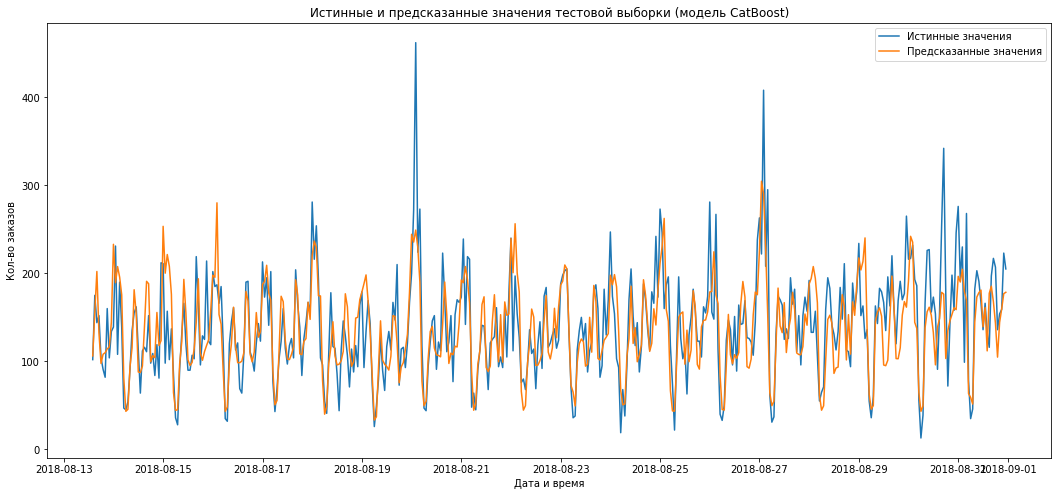

In [35]:
# Визуализируем истинные и предсказанные значения тестовой выборки
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(y_test.index, y_test, label='Истинные значения')
ax.plot(y_test.index, predictions_test, label='Предсказанные значения')
plt.title('Истинные и предсказанные значения тестовой выборки (модель СatBoost)')
plt.xlabel('Дата и время')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show();

## Выводы

Поскольку перед нами стояла задача прогнозирования количества заказов такси на следующий час мы провели ресемплирование данных с переходом от 10-минутного временного промежутка на часовой промежуток.

В ходе анализа данных мы обнаружили, что:
- данные о количестве заказов такси представлены в период с полуночи (00 часов) 01 марта 2018 года по 11 часов вечера (23 часа) 31 августа 2018 года;
- в данных отсутствовали пропуски и нетипичные для задачи значения. Однако ближе к концу периода - в августе было отмечено несколько пиков нетипично высокого количества заказов;
- к концу рассматриваемого периода возрастает не только скользящее среднее, но и под конец становится больше стандартное отклонение.  
- при разложении временного ряда на тренд, сезонность и остатки:
    - был выявлен плавный возрастающий тренд количества заказов
    - была выявлена суточная сезонность количества заказов такcи;
    - график остатков выглядит достаточно ровно: разброс и средняя остатков не сильно изменяются во времени;
- к концу рассматриваемого периода возрастает не только скользящее среднее за 24 часа, но и под конец становится больше стандартное отклонение за 24 часа.

При подготовке данных к обучению, мы добавили ряд переменных для сглаживания наличия выбросов и учета суточнойсезонности (скользящие средние за 5 дней и за 24 часа), получения более стационарного временного ряда (лаг в 24 часа), а также вытащили из даты заказа признаки часа, дня, дня недели и месяца. Размер тестовой выборки мы установили как 10%. Также перед обучением было проведено масштабированние данных с помощью StandardScaler.

Мы обучили три разных модели: модель линейной регрессии, дерева решений и CatBoost. C точки зрения качества лучшей моделью оказалась модель CatBoost. Предсказание количества заказов такси в час этой модели по результатам кросс-валидации отличается от истинных значений на 27.42 заказов. На тестовой выборке качество модели было хуже: целевая метрика RMSE составила 52,13 заказов.

Анализ важности признаков позволил нам увидеть, что для предсказания количества заказов такси на ближайший час:
- наиболее важными из признаков являются час (`hour` -  importance 40,05%), сдвиг данных на сутки назад (`lag_24` - importance 21,10%) и день недели (`dayofweek` - importance 11,71%);
- менее важными являются месяц (`month` - importnace 9,46%), скользящая средняя с окном 24 часа (`rolling_mean` - importance 6,90%), скользящая средняя за 5 дней (`rolling_mean_5d` - importance 5,67%);
- cамыми незначимыми признаками являются день и признак выходного дня.

Мы исключили из рассмотрения наименее значимые признаки, что позволило нам улучшить качество выбранной нами модели: RMSE на тестовой выборке снизилось до 40,44 заказов, что удовлетворяет уровню, указанному в ТЗ.

Из графика сравнения истинных и предсказанных значений числа заказов такси из аэропорта в час, мы видим, что предсказания достаточно близки к истинным значениям, если не считать имеющиеся фактические выбросы в числе заказов. 

Точность предсказания, вероятно можно было бы повысить:
- если бы мы рассматривали данные за больший временной промежуток,  за счет чего могли бы учесть сезонность по временам года, если она присутствует;
- если бы мы могли дополнительно проанализировать и при необходимости учесть, иные факторы, которые могут влиять на количество заказов такси (например, прогноз погоды, перерывы в работе иных видов транспорта и т.п.).